In [13]:
import sys, os

# Point to project root (one level above /notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to PYTHONPATH:", project_root)


Project root added to PYTHONPATH: /home/jasnoorpannu/CSE/Projects/dropout-predictor


In [ ]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from src.config import RAW_DATA, MODEL_PATH
from src.preprocessing import load_raw, prepare_features

In [ ]:
RANDOM_STATE = 42
CUTOFF_DAY = 60 
model = joblib.load(MODEL_PATH)
print("Model loaded successfully.")

raw = load_raw(RAW_DATA)

Dataset shape: (26074, 10)


,id_student,total_clicks,avg_clicks,max_daily_clicks,min_daily_clicks,std_clicks,active_days,engagement_trend,days_since_last_active,dropout
0,6516,2791.0,17.553459,142.0,1.0,20.385105,159,-0.055514,0,0
1,8462,656.0,11.714286,136.0,1.0,20.290360,56,-0.347163,0,1
2,11391,934.0,23.350000,127.0,1.0,27.820441,40,-0.663790,0,0
3,23629,161.0,10.062500,26.0,1.0,6.607761,16,0.192647,0,0
4,23698,910.0,13.000000,128.0,1.0,23.474933,70,0.026489,0,0


In [ ]:
df = prepare_features(raw, cutoff=CUTOFF_DAY) 

X = df.drop(["id_student", "dropout"], axis=1)
y = df["dropout"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Validation set size: {X_val.shape[0]} students.")

(20859, 8) (5215, 8)


In [ ]:
y_proba = model.predict(X_val)

THRESHOLD = 0.5
y_pred = (y_proba > THRESHOLD).astype(int)

In [ ]:
auc_score = roc_auc_score(y_val, y_proba)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)


print(f"Validation AUC Score: {auc_score:.4f} (Primary Metric)")
print("---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + classification_report(y_val, y_pred))

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Stay (0)', 'Actual Dropout (1)'], columns=['Predicted Stay (0)', 'Predicted Dropout (1)'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', linewidths=.5, linecolor='gray')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

AUC: 0.7578
Average Precision: 0.5122
Precision: 0.5847
Recall:    0.2984
F1 Score:  0.3951


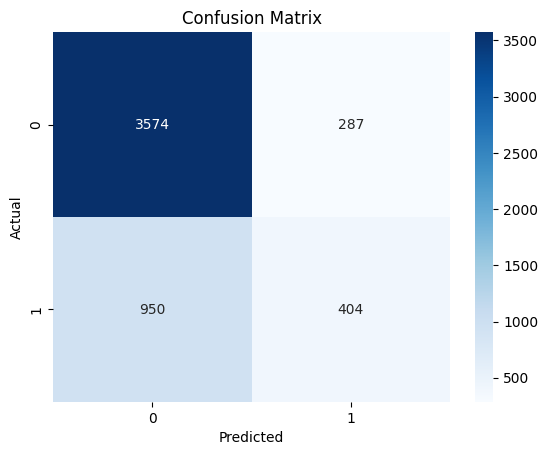

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

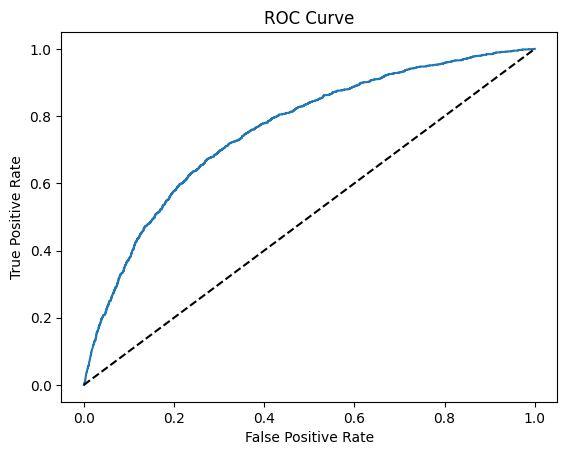

In [ ]:
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 8), title='Feature Importance (Gain)')
plt.show()


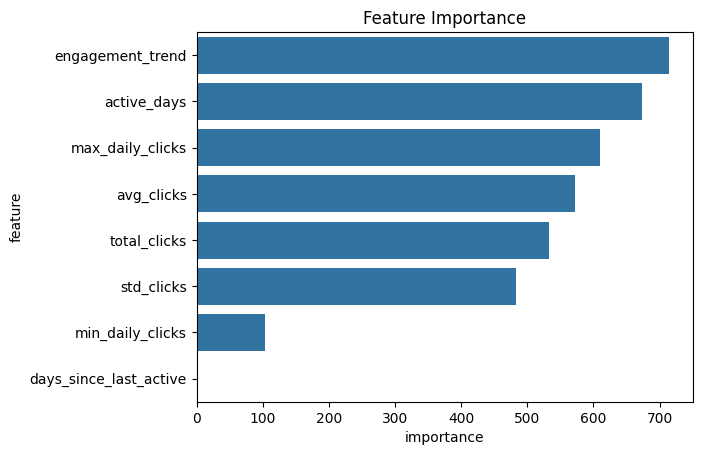

In [ ]:
importances = model.feature_importance()
names = model.feature_name()

fi = pd.DataFrame({"feature": names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)
fi
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Feature Importance")
plt.show()


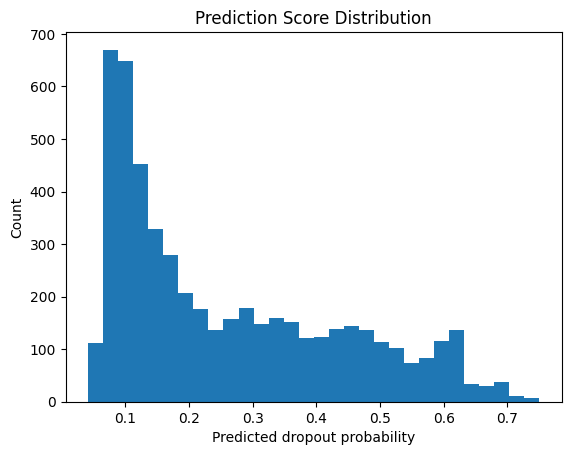

In [ ]:
plt.hist(preds, bins=30)
plt.title("Prediction Score Distribution")
plt.xlabel("Predicted dropout probability")
plt.ylabel("Count")
plt.show()


In [ ]:
scores = []

for seed in [1, 7, 21, 42, 133]:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # retrain simple LGBM just for stability check
    import lightgbm as lgb
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1
    }

    model_temp = lgb.train(params, train_data, valid_sets=[val_data],
                           callbacks=[lgb.early_stopping(50)],
                           num_boost_round=500)

    preds_temp = model_temp.predict(X_val)
    auc_temp = roc_auc_score(y_val, preds_temp)
    scores.append(auc_temp)

scores


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.746964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.76269
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.762342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.756751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.761054


[0.7469644940102842,
 0.7626904388351952,
 0.762342395281834,
 0.7567513180511702,
 0.7610539933287348]